In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dataset

In [4]:
def load_australian_dataset(path):    
    data = np.loadtxt(path)
    X = data[:, :-1]   # first 14 columns
    y = data[:, -1]    # last column
    # Convert labels to {-1, +1}
    y = np.where(y > 0, 1.0, -1.0)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # Add bias term (intercept)
    X = np.hstack([X, np.ones((X.shape[0], 1))])

    return X, y

X, y = load_australian_dataset("australian.dat")
print(X.shape)
print(y.shape)


(690, 15)
(690,)


In [5]:
# Training and test data
# temp could be useful for tuning hyperparameters

RND = 0

# train/val/test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=RND, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RND, stratify=y_temp)
# 0.25 of 0.8 = 0.2, so 60/20/20 split

print("Train / val / test sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])

# scale *without* the bias column
scaler = StandardScaler().fit(X_train[:, :-1])
X_train_s = X_train.copy()
X_val_s   = X_val.copy()
X_test_s  = X_test.copy()

X_train_s[:, :-1] = scaler.transform(X_train[:, :-1])
X_val_s[:, :-1]   = scaler.transform(X_val[:, :-1])
X_test_s[:, :-1]  = scaler.transform(X_test[:, :-1])

Train / val / test sizes: 414 138 138


# Standard Logistic Regression (For Comparison)

In [6]:
def classification_scores(y_true, y_pred, average='macro'):
    res = {}
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # --- Core classification metrics ---
    res['accuracy'] = metrics.accuracy_score(y_true, y_pred)
    res['balanced_accuracy'] = metrics.balanced_accuracy_score(y_true, y_pred)
    res[f'precision_{average}'] = metrics.precision_score(y_true, y_pred, average=average, zero_division=0)
    res[f'recall_{average}'] = metrics.recall_score(y_true, y_pred, average=average, zero_division=0)
    res[f'f1_{average}'] = metrics.f1_score(y_true, y_pred, average=average, zero_division=0)

    # --- Confusion matrix & full text report ---
    try:
        res['confusion_matrix'] = metrics.confusion_matrix(y_true, y_pred)
    except Exception:
        res['confusion_matrix'] = None

    return res

In [7]:
clf = LogisticRegression(max_iter=2000, random_state=RND, fit_intercept=False)
clf.fit(X_train_s, y_train)
y_true = y_test
y_pred = clf.predict(X_test_s)
res_log = classification_scores(y_test, y_pred)

print("\n=== Logistic Regression Metrics ===")
for k in ['accuracy', 'balanced_accuracy', 'precision_macro', 'recall_macro', 'f1_macro']:
    v = res_log.get(k, np.nan)
    print(f"{k:20s}: {v:.4f}")


=== Logistic Regression Metrics ===
accuracy            : 0.8696
balanced_accuracy   : 0.8695
precision_macro     : 0.8673
recall_macro        : 0.8695
f1_macro            : 0.8682


[[67 10]
 [ 8 53]]


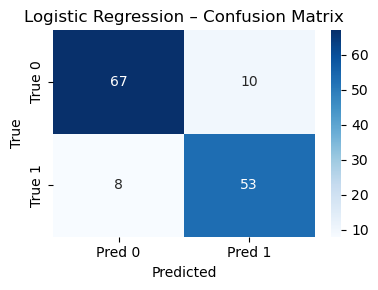

In [8]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

def plot_confusion_matrix(y_true, y_pred, title="Confusion matrix"):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(4,3))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=True,
        xticklabels=["Pred 0", "Pred 1"],
        yticklabels=["True 0", "True 1"],
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig("confusion_opti.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_confusion_matrix(y_test, y_pred, title="Logistic Regression – Confusion Matrix")

#plt.savefig("confusion.png", dpi=300, bbox_inches="tight")

[ 0.02330511 -0.10288894 -0.108568    0.1164015   0.45938827  0.15439127
  0.2841725   1.681876    0.34327546  0.35007127 -0.2820541   0.32555876
 -0.08246326  1.14321401 -0.33900481]


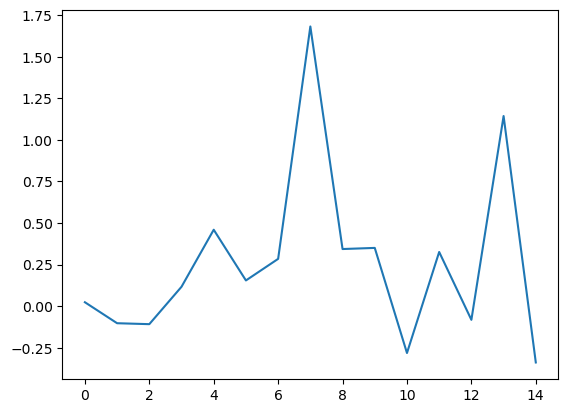

In [9]:
# Logitsic Regression parameters
theta = clf.coef_.ravel()
print(theta)
plt.plot(theta)

# Sampling Algorithms

In [10]:
sigma0_sq = 0.5  # prior variance (In paper)

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def grad_log_prior(theta):
    return -theta / sigma0_sq

def grad_log_lik_full(theta, X, y):
    z = y * (X @ theta) # Easy of notation
    return (X.T @ (y * (1.0 - sigmoid(z))))

def grad_log_lik_minibatch(theta, X_batch, y_batch, N_total):
    m = len(y_batch)
    z = y_batch * (X_batch @ theta)
    g_batch = X_batch.T @ (y_batch * (1.0 - sigmoid(z)))
    return (N_total / m) * g_batch

# Unsure of purpose
def accuracy_from_theta(theta, X, y):
    preds = np.sign(X @ theta)
    return (preds == y).mean()

## MALA

In [11]:
def log_lik(theta, X, y):
    z = y * (X @ theta)
    return np.sum(-np.log(1 + np.exp(-z)))   # log σ(z) = -log(1+exp(-z))


def log_prior(theta):
    return -0.5 * np.sum(theta**2) / sigma0_sq


def log_posterior(theta, X, y):
    return log_lik(theta, X, y) + log_prior(theta)

In [12]:
def run_mala(X, y, T=20000, eps=5e-3,  seed=0):

    rng = np.random.default_rng(seed)
    N, D = X.shape
    theta = np.zeros(D)  # init
    samples = []
    accepts = 0

    # log posterior at current θ
    log_post = log_posterior(theta, X, y)

    for t in range(T):
        # ----- 1. Gradient at current θ -----
        g_lik = grad_log_lik_full(theta, X, y)
        g_prior = grad_log_prior(theta)
        g = g_lik + g_prior  # ∇ log π(θ)

        # ----- 2. Forward proposal: θ' ~ N( θ + (ε/2)g, ε I ) -----
        mean_forward = theta + 0.5 * eps * g
        theta_prop = mean_forward + np.sqrt(eps) * rng.normal(size=theta.shape)

        # ----- 3. Log posterior at θ' -----
        log_post_prop = log_posterior(theta_prop, X, y)

        # ----- 4. Gradient at θ' (for reverse proposal) -----
        g_lik_prop = grad_log_lik_full(theta_prop, X, y)
        g_prior_prop = grad_log_prior(theta_prop)
        g_prop = g_lik_prop + g_prior_prop

        # backward proposal mean: q(θ | θ') = N( θ; θ' + (ε/2)∇ log π(θ'), ε I )
        mean_backward = theta_prop + 0.5 * eps * g_prop

        # ----- 5. Log proposal densities (up to constant) -----
        # log q(θ' | θ)
        log_q_forward = -0.5 / eps * np.sum((theta_prop - mean_forward)**2)
        # log q(θ | θ')
        log_q_backward = -0.5 / eps * np.sum((theta - mean_backward)**2)

        # ----- 6. MH acceptance log-ratio -----
        log_alpha = (log_post_prop + log_q_backward) - (log_post + log_q_forward)

        if np.log(rng.random()) < log_alpha:
            # accept
            theta = theta_prop
            log_post = log_post_prop
            accepts += 1

        # always store the current θ (accepted or not)
        samples.append(theta.copy())

    samples = np.array(samples)
    acc_rate = accepts / T
    
    return samples, acc_rate

## RWM

In [13]:
def run_mh(X, y, T=5000, proposal_std=0.1,  seed=1):
   
    rng = np.random.default_rng(seed)
    N, D = X.shape
    theta = np.zeros(D)  # initial value
    samples = []
    accepts = 0

    # log posterior at current θ
    log_post = log_posterior(theta, X, y)

    for t in range(T):
        # ----- 1. Proposal: θ' ~ N(θ, proposal_std^2 I) -----
        theta_prop = theta + proposal_std * rng.normal(size=theta.shape)

        # ----- 2. Log posterior at θ' -----
        log_post_prop = log_posterior(theta_prop, X, y)

        # ----- 3. MH acceptance log-ratio (q cancels since proposal is symmetric) -----
        log_alpha = log_post_prop - log_post

        # ----- 4. Accept/reject -----
        if np.log(rng.random()) < log_alpha:
            theta = theta_prop
            log_post = log_post_prop
            accepts += 1

        # store current θ (accepted or not)
        samples.append(theta.copy())

    samples = np.array(samples)
    acc_rate = accepts / T
    return samples, acc_rate


## SGLD

In [14]:
def run_sgld(X, y, T, eps0, gamma=0.55, batch_size=1000, seed=1):
    rng = np.random.default_rng(seed)
    N, D = X.shape
    theta = np.zeros(D)
    samples = []
    #eps_t_arr = []
    
    indices = np.arange(N)
    t = 0

    while t < T:
        rng.shuffle(indices)

        # process whole dataset in minibatches
        for start in range(0, N, batch_size):
            t += 1
            if t > T:
                break

            batch_idx = indices[start:start + batch_size]
            Xb = X[batch_idx]
            yb = y[batch_idx]

            # Robbins–Monro scaling: (N / batch_size)
            g_lik = grad_log_lik_minibatch(theta, Xb, yb, N_total=N)
            g_prior = grad_log_prior(theta)
            g = g_lik + g_prior

            eps_t = eps0 * (t ** -gamma)
            noise = np.sqrt(eps_t) * rng.normal(size=theta.shape)

            theta = theta + 0.5 * eps_t * g + noise

            samples.append(theta.copy())
            #eps_t_arr.append(eps_t)

    return np.array(samples) #np.array(eps_t_arr)


# Fit Parameters

In [15]:
def tune_mala_eps(X, y, eps_grid, T_short=5000, seed=0):
    print("Tuning MALA eps:")
    best_eps, best_err = None, 1e9
    target = 0.6

    for eps in eps_grid:
        _, acc = run_mala(X, y, T=T_short, eps=eps, seed=seed)  # unpack acceptance
        print(f"  eps={eps:.2e} -> acceptance={acc:.3f}")
        err = abs(acc - target)
        if err < best_err:
            best_err, best_eps = err, eps

    print(f"\nChosen eps ≈ {best_eps:.2e} (closest to target {target})")
    return best_eps

eps_grid = [1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2]
best_eps = tune_mala_eps(X_temp, y_temp, eps_grid)

Tuning MALA eps:
  eps=1.00e-03 -> acceptance=0.995
  eps=2.00e-03 -> acceptance=0.985
  eps=5.00e-03 -> acceptance=0.949
  eps=1.00e-02 -> acceptance=0.838
  eps=2.00e-02 -> acceptance=0.550
  eps=5.00e-02 -> acceptance=0.000

Chosen eps ≈ 2.00e-02 (closest to target 0.6)


In [16]:
def tune_mh_sigma(X, y, sigma_grid, T_short=5000, seed=0):
    print("Tuning MH proposal_std:")
    best_sigma, best_err = None, 1e9
    target = 0.25   # ideal acceptance in high dimension

    for s in sigma_grid:
        _, acc = run_mh(X, y, proposal_std=s, T=T_short, seed=seed)   # unpack!
        print(f"  sigma={s:.3g} -> acceptance={acc:.3f}")
        err = abs(acc - target)
        if err < best_err:
            best_err, best_sigma = err, s

    print(f"\nChosen sigma ≈ {best_sigma:.3g}")
    return best_sigma


sigma_grid = [0.01, 0.02, 0.05, 0.1, 0.2]
best_sigma = tune_mh_sigma(X_temp, y_temp, sigma_grid)

Tuning MH proposal_std:
  sigma=0.01 -> acceptance=0.889
  sigma=0.02 -> acceptance=0.804
  sigma=0.05 -> acceptance=0.526
  sigma=0.1 -> acceptance=0.214
  sigma=0.2 -> acceptance=0.018

Chosen sigma ≈ 0.1


In [17]:
def tune_sgld_eps0(X, y, eps0_grid, theta_ref, T_short=5000, gamma=0.55, batch_size=5, seed=0):
    """
    Tune SGLD initial step size eps0 by minimizing posterior mean distance to reference (MH/MALA).
    """
    print("Tuning SGLD eps0 (matching posterior mean to reference):")
    best_eps0, best_err = None, 1e9

    for eps0 in eps0_grid:
        samples = run_sgld(X, y, T=T_short, eps0=eps0, gamma=gamma, batch_size=batch_size, seed=seed)
        mean_sgld = samples.mean(axis=0)

        err = np.linalg.norm(mean_sgld - theta_ref)
        print(f"  eps0={eps0:.1e} -> mean error={err:.4f}")

        if err < best_err:
            best_err, best_eps0 = err, eps0

    print(f"\nChosen SGLD eps0 ≈ {best_eps0:.1e} (closest to reference posterior)")
    return best_eps0

T = 5000
burn_small = T // 10
samples_mala = run_mala(X_train, y_train, T=T, eps=2.00e-02, seed=0)
theta_mala_samples = samples_mala[0][burn_small:]

theta_ref = theta_mala_samples.mean(axis=0)   # reference posterior mean

eps0_grid = [1e-1, 5e-2, 1e-2, 5e-3]
best_eps0_sgld = tune_sgld_eps0(X_temp, y_temp, eps0_grid, theta_ref)

Tuning SGLD eps0 (matching posterior mean to reference):
  eps0=1.0e-01 -> mean error=0.5794
  eps0=5.0e-02 -> mean error=0.4872
  eps0=1.0e-02 -> mean error=0.6111
  eps0=5.0e-03 -> mean error=0.7071

Chosen SGLD eps0 ≈ 5.0e-02 (closest to reference posterior)


## eps0

Burn-in


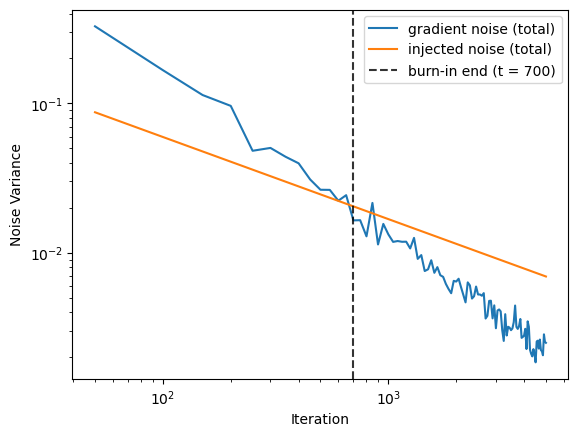

In [18]:
def estimate_var_h_diag(theta, X, y, batch_size, K=50, seed=0):
   
    rng = np.random.default_rng(seed)
    N, D = X.shape

    # Full gradient of log posterior at theta
    g_full = grad_log_prior(theta) + grad_log_lik_full(theta, X, y)

    hs = np.empty((K, D))
    for k in range(K):
        idx = rng.choice(N, size=batch_size, replace=False)
        Xb, yb = X[idx], y[idx]

        # Your minibatch gradient estimator already includes N/m scaling
        g_hat = grad_log_prior(theta) + grad_log_lik_minibatch(theta, Xb, yb, N_total=N)

        hs[k] = g_hat - g_full

    # diagonal variance (coordinate-wise)
    return hs.var(axis=0, ddof=1)


def collect_total_noise_curves(X, y, T=20000, eps0=5e-2, gamma=0.55, batch_size_sgld=10, K_var=50, every=50, seed=0,):
    rng = np.random.default_rng(seed)
    N, D = X.shape
    theta = np.zeros(D)

    its = []
    grad_noise_total = []
    inj_noise_total = []

    indices = np.arange(N)
    t = 0

    while t < T:
        rng.shuffle(indices)

        for start in range(0, N, batch_size_sgld):
            t += 1
            if t > T:
                break

            batch_idx = indices[start:start + batch_size_sgld]
            Xb = X[batch_idx]
            yb = y[batch_idx]

            # Your scaled minibatch gradient (includes N/m)
            g = grad_log_prior(theta) + grad_log_lik_minibatch(theta, Xb, yb, N_total=N)

            eps_t = eps0 * (t ** -gamma)

            # SGLD update (paper convention)
            theta = theta + 0.5 * eps_t * g + np.sqrt(eps_t) * rng.normal(size=theta.shape)

            # Every few iterations, estimate gradient-noise variance at current theta
            if t % every == 0:
                var_h_diag = estimate_var_h_diag(theta, X, y, batch_size=batch_size_sgld, K=K_var, seed=seed + t)

                # Var((eps/2) * h_j) = (eps/2)^2 * Var(h_j)
                var_update_diag = (0.5 * eps_t) ** 2 * var_h_diag

                # TOTAL gradient-noise variance (trace approx: sum of diagonal variances)
                grad_noise_total.append(var_update_diag.sum())

                # TOTAL injected-noise variance = trace(eps I) = D * eps
                inj_noise_total.append(D * eps_t)

                its.append(t)

    return np.array(its), np.array(grad_noise_total), np.array(inj_noise_total)



its, grad_total, inj_total = collect_total_noise_curves(X_temp, y_temp, T=5000, eps0=5e-2, gamma=0.55,
    batch_size_sgld=10, K_var=50, every=50, seed=0)


mask = inj_total >= grad_total
if np.any(mask):
    idx_cross = np.argmax(mask)  # first True
    t_cross = its[idx_cross]
    print(f"Burn-in")
else:
    t_cross = None
    print("No intersection found: injected noise never dominates.")


plt.figure()
plt.loglog(its, grad_total, label=r"gradient noise (total)")
plt.loglog(its, inj_total, label=r"injected noise (total)")

if t_cross is not None:
    plt.axvline(
        t_cross,
        linestyle="--",
        color="black",
        alpha=0.8,
        label=f"burn-in end (t = {t_cross})"
    )

plt.xlabel("Iteration")
plt.ylabel("Noise Variance")
plt.legend()
plt.show()



# Run Experiment

In [19]:
T = 5100
samples_mala, acc_mala  = run_mala(X_train, y_train, T=T, eps=2.00e-02, seed=0)
samples_mala.shape

T = 5500
samples_mh, acc_mh = run_mh(X_train, y_train, T=T, proposal_std=0.1)
samples_mh.shape

T = 7000
samples_sgld = run_sgld(X_train, y_train, T=T, eps0=5.0e-02, gamma=0.55, batch_size = 10, seed=0)
samples_sgld.shape

(7000, 15)

# Burn in

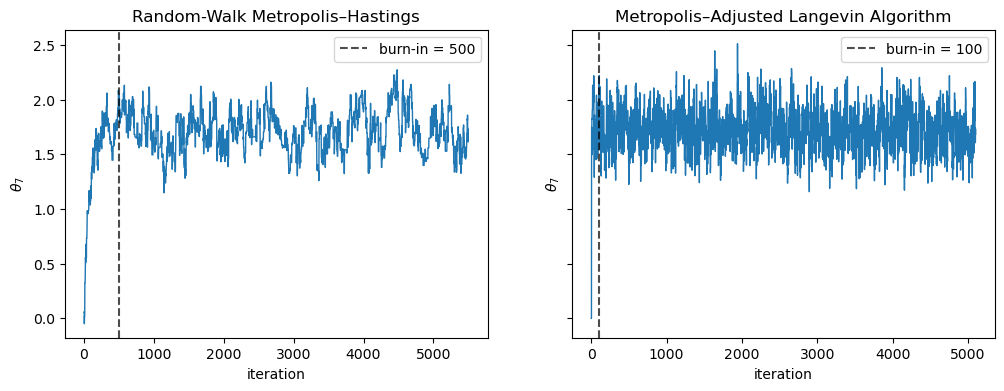

In [20]:
trace_mh = samples_mh[:, 7]
burn_in_mh = 500

trace_mala = samples_mala[:, 7]
burn_in_mala = 100

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].plot(trace_mh, linewidth=1)
axes[0].axvline(burn_in_mh, linestyle="--", color="black", alpha=0.7, label=f"burn-in = {burn_in_mh}")
axes[0].set_xlabel("iteration")
axes[0].set_ylabel(r"$\theta_{7}$")
axes[0].set_title("Random-Walk Metropolis–Hastings")
axes[0].legend()

axes[1].plot(trace_mala, linewidth=1)
axes[1].axvline(burn_in_mala, linestyle="--", color="black", alpha=0.7, label=f"burn-in = {burn_in_mala}")
axes[1].set_xlabel("iteration")
axes[1].set_ylabel(r"$\theta_{7}$")
axes[1].set_title("Metropolis–Adjusted Langevin Algorithm")
axes[1].legend()


plt.savefig("trace_mh_vs_mala_burnin.png", dpi=300, bbox_inches="tight")
plt.show()

# Diagnostic Tests

MALA posterior mean: [ 0.02739802 -0.08694052 -0.09178848  0.11332435  0.46803449  0.16919667
  0.29045286  1.72143038  0.37464499  0.43915061 -0.27996669  0.35898765
 -0.10047279  1.08187427 -0.40145874]
MH posterior mean: [ 0.01832333 -0.07599933 -0.0467045   0.10424315  0.48729494  0.1401301
  0.27870884  1.7175717   0.40065881  0.38769101 -0.26301104  0.36110667
 -0.10862281  0.72521451 -0.47781854]
SGLD posterior mean: [ 0.04246669 -0.1081496  -0.03058053  0.10940042  0.56364966  0.14189837
  0.32713565  1.71745693  0.26155915  0.54906193]
MALA posterior standard deviation: [0.16658809 0.16692408 0.17634177 0.16241534 0.18600575 0.17269037
 0.20400386 0.18404796 0.20515404 0.31257522 0.16011297 0.16278249
 0.17093216 0.50908364 0.18618328]
MH posterior standard deviation: [0.15402189 0.16113856 0.17678669 0.16944517 0.18675453 0.17043675
 0.20388086 0.18395588 0.219391   0.27065379 0.15781203 0.16364239
 0.17118927 0.39451864 0.17382657]
SGLD posterior standard deviation: [0.17522

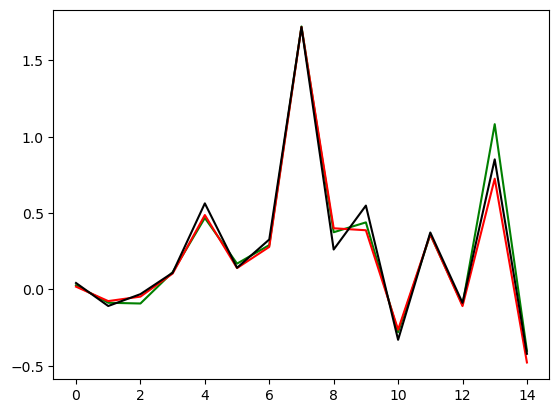

In [34]:
burn_in_sgld = 2000
theta_sgld_samples = samples_sgld[burn_in_sgld::]

burn_in_mala = 100
theta_mala_samples = samples_mala[burn_in_mala:]

burn_in_mh = 500
theta_mh_samples = samples_mh[burn_in_mh::]

print("MALA posterior mean:", theta_mala_samples.mean(axis=0))
print("MH posterior mean:", theta_mh_samples.mean(axis=0))
print("SGLD posterior mean:", theta_sgld_samples.mean(axis=0)[:10])
print("MALA posterior standard deviation:",  theta_mala_samples.std(axis=0))
print("MH posterior standard deviation:",  theta_mh_samples.std(axis=0))
print("SGLD posterior standard deviation:",  theta_sgld_samples.std(axis=0))

print("MAlA test acc (mean theta):",accuracy_from_theta(theta_mala_samples.mean(axis=0), X_test, y_test))
print("MH posterior (mean: theta)", accuracy_from_theta(theta_mh_samples.mean(axis=0), X_test, y_test))
print("SGLD test acc (mean theta):",accuracy_from_theta(theta_sgld_samples.mean(axis=0), X_test, y_test))

plt.plot(theta_mala_samples.mean(axis=0), color = 'green')
plt.plot(theta_mh_samples.mean(axis=0), 'red')
plt.plot(theta_sgld_samples.mean(axis=0), 'black')

# Confusion Matrices

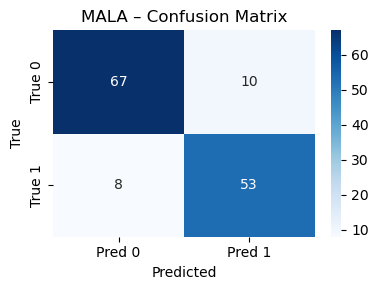

In [22]:
theta_mala = theta_mala_samples.mean(axis=0)
y_pred_mala = np.sign(X_test @ theta_mala)
plot_confusion_matrix(y_test, y_pred_mala, title="MALA – Confusion Matrix")



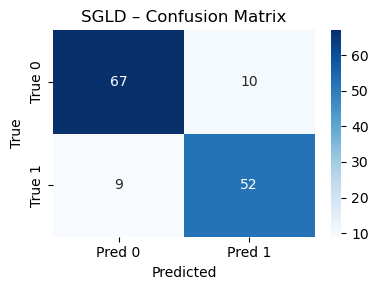

In [23]:
theta_sgld = theta_sgld_samples.mean(axis=0)
y_pred_sgld = np.sign(X_test @ theta_sgld)
plot_confusion_matrix(y_test, y_pred_sgld, title="SGLD – Confusion Matrix")


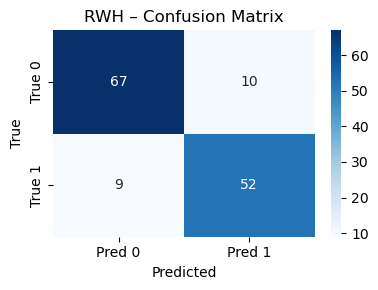

In [24]:
theta_mh = theta_mh_samples.mean(axis=0)
y_pred_mh = np.sign(X_test @ theta_mh)
plot_confusion_matrix(y_test, y_pred_mh, title="RWH – Confusion Matrix")


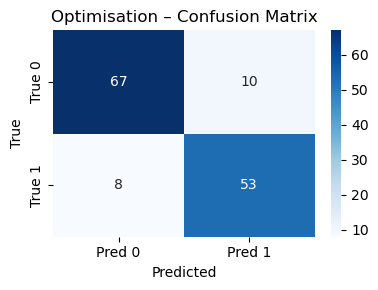

In [25]:
plot_confusion_matrix(y_test, y_pred, title="Optimisation – Confusion Matrix")


## Plot Marginal Posterior Distrubutions

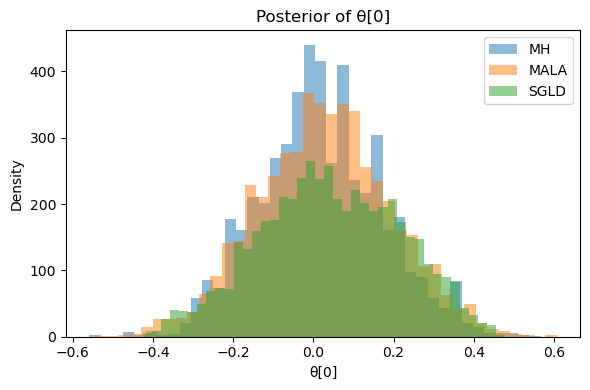

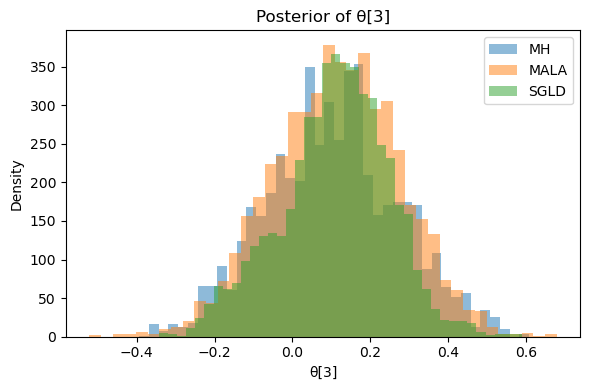

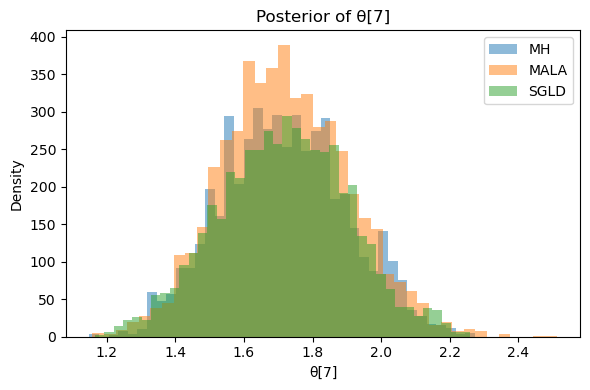

(5000, 15)

In [26]:
indices = [0,3,7]  # example

for j in indices:
    plt.figure(figsize=(6,4))
    plt.hist(theta_mh_samples[:, j],   bins=40, alpha=0.5, label="MH")
    plt.hist(theta_mala_samples[:, j], bins=40, alpha=0.5, label="MALA")
    plt.hist(theta_sgld_samples[:, j], bins=40, alpha=0.5, label="SGLD")
    plt.legend()
    plt.title(f"Posterior of θ[{j}]")
    plt.xlabel(f"θ[{j}]")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

# SGLD much less important here can be removed
theta_mh_samples.shape

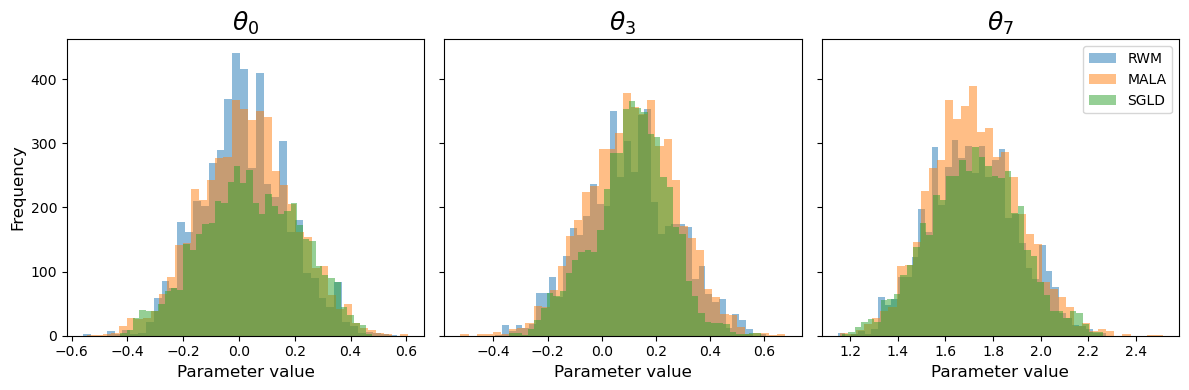

In [27]:
param_indices = [0, 3, 7]

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for ax, idx in zip(axes, param_indices):
    ax.hist(theta_mh_samples[:, idx],   bins=40, alpha=0.5, label="RWM")
    ax.hist(theta_mala_samples[:, idx], bins=40, alpha=0.5, label="MALA")
    ax.hist(theta_sgld_samples[:, idx], bins=40, alpha=0.5, label="SGLD")

    ax.set_title(f"$\\theta_{{{idx}}}$", fontsize = 18)
    ax.set_xlabel("Parameter value", fontsize = 12)

axes[0].set_ylabel("Frequency", fontsize = 12)
axes[-1].legend()

plt.tight_layout()

plt.savefig("parameter_dist.png", dpi=300, bbox_inches="tight")

plt.show()



# Effective Sample Size

In [28]:
import arviz as az
import time

T = 5100

start = time.time()
theta_mala_samples, acc_mala = run_mala(X_train, y_train, T=T, eps=2.00e-02, seed=0)
end = time.time()

runtime_mala = end - start
print("MALA runtime (s):", runtime_mala)

burn_in_mala = 100
theta_mala_samples = theta_mala_samples[burn_in_mala::]

samples = theta_mala_samples[np.newaxis, ...]               
idata = az.from_dict(posterior={"theta": samples})
ess_vals = az.ess(idata, var_names=["theta"], method="bulk")["theta"].values  # shape (dim,)

ess_median = np.min(ess_vals)
ess_per_second = ess_median / runtime_mala

print("ESS median:", ess_median)
print("ESS/sec (MALA):", ess_per_second)

MALA runtime (s): 0.23499107360839844
ESS median: 103.0628775305396
ESS/sec (MALA): 438.58209568542605


In [29]:
T = 5500

start = time.time()
theta_mh_samples, acc_mh = run_mh(X_train, y_train, T=T, proposal_std=0.1)
end = time.time()

runtime_mh = end - start
print("Mh runtime (s):", runtime_mh)

burn_in_mh = 500
theta_mh_samples = theta_mh_samples[burn_in_mh::]

samples = theta_mh_samples[np.newaxis, ...]              
idata = az.from_dict(posterior={"theta": samples})
ess_vals = az.ess(idata, var_names=["theta"], method="bulk")["theta"].values  # shape (dim,)

ess_median = np.min(ess_vals)
ess_per_second = ess_median / runtime_mh

print("ESS median:", ess_median)
print("ESS/sec (MH):", ess_per_second)

# Results are exactly what we would expect maybe look at post burn in. 

Mh runtime (s): 0.09710693359375
ESS median: 27.26189921362776
ESS/sec (MH): 280.74101616346775


In [30]:
T = 7000
start = time.time()
theta_mh_samples = run_sgld(X_train, y_train, T=T, eps0=5e-02, gamma=0.55, batch_size = 15, seed=0)
end = time.time()

runtime_mh = end - start
print("SGLD runtime (s):", runtime_mh)

burn_in_sgld = 2000
theta_sgld_samples = theta_mh_samples[burn_in_sgld::]

samples = theta_mh_samples[np.newaxis, ...]              
idata = az.from_dict(posterior={"theta": samples})
ess_vals = az.ess(idata, var_names=["theta"], method="bulk")["theta"].values  # shape (dim,)

ess_median = np.median(ess_vals)
ess_per_second = ess_median / runtime_mh

print("ESS median:", ess_median)
print("ESS/sec (SGLD):", ess_per_second)

SGLD runtime (s): 0.06791806221008301
ESS median: 38.08635997238776
ESS/sec (SGLD): 560.7692377114599


# Uncertainity Quantification

In [31]:
probs_mala = sigmoid(X_test @ theta_mala_samples.T)   # (N_test, S)
mean_prob_mala = probs_mala.mean(axis=1)
ci_low_mala    = np.quantile(probs_mala, 0.05, axis=1)
ci_high_mala   = np.quantile(probs_mala, 0.95, axis=1)

probs_mh = sigmoid(X_test @ theta_mh_samples.T)   # (N_test, S)
mean_prob_mh = probs_mh.mean(axis=1)
ci_low_mh    = np.quantile(probs_mh, 0.05, axis=1)
ci_high_mh   = np.quantile(probs_mh, 0.95, axis=1)

probs_sgld = sigmoid(X_test @ theta_sgld_samples.T)   # (N_test, S)
mean_prob_sgld = probs_mh.mean(axis=1)
ci_low_sgld    = np.quantile(probs_sgld, 0.05, axis=1)
ci_high_sgld   = np.quantile(probs_sgld, 0.95, axis=1)

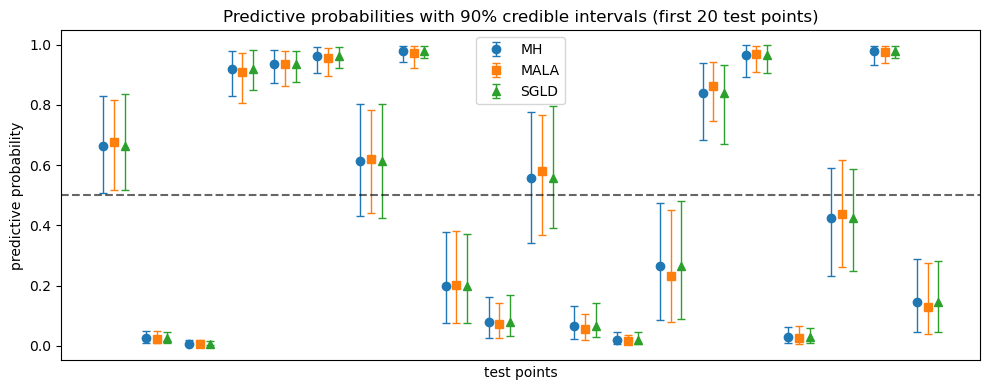

In [32]:
# first 20 test points
idx = np.arange(20)
xpos = np.arange(len(idx))

def plot_method(ax, means, low, high, offset, label, marker):
    m = means[idx]
    lo = low[idx]
    hi = high[idx]
    yerr = np.vstack([m - lo, hi - m])
    ax.errorbar(
        xpos + offset,
        m,
        yerr=yerr,
        fmt=marker,
        capsize=3,
        linewidth=1,
        label=label
    )

plt.figure(figsize=(10,4))
ax = plt.gca()

# plot each sampler with different offsets / markers
plot_method(ax, mean_prob_mh,   ci_low_mh,   ci_high_mh,   offset=-0.25, label="MH",   marker="o")
plot_method(ax, mean_prob_mala, ci_low_mala, ci_high_mala, offset=0.00,  label="MALA", marker="s")
plot_method(ax, mean_prob_sgld, ci_low_sgld, ci_high_sgld, offset=0.25,  label="SGLD", marker="^")

# reference line
ax.axhline(0.5, linestyle="--", color="black", alpha=0.6)

ax.set_xlabel("test points")
ax.set_ylabel("predictive probability")
ax.set_title("Predictive probabilities with 90% credible intervals (first 20 test points)")
ax.set_xticks([])

ax.legend()
plt.tight_layout()
plt.show()


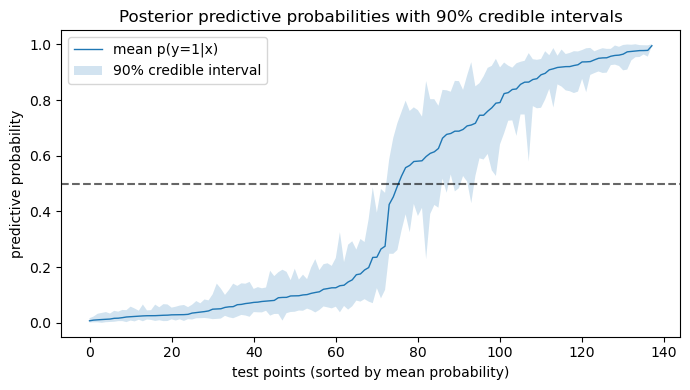

In [33]:
# sort by mean probability for a clean plot
order = np.argsort(mean_prob_sgld)

plt.figure(figsize=(7,4))
plt.plot(mean_prob_sgld[order], linewidth=1, label="mean p(y=1|x)")
plt.fill_between(np.arange(len(mean_prob_sgld)), ci_low_sgld[order], ci_high_sgld[order], alpha=0.2, label="90% credible interval")
plt.axhline(0.5, linestyle="--", color="black", alpha=0.6)
plt.xlabel("test points (sorted by mean probability)")
plt.ylabel("predictive probability")
plt.title("Posterior predictive probabilities with 90% credible intervals")
plt.legend()
plt.tight_layout()


plt.savefig("post_pred_prob.png", dpi=300, bbox_inches="tight")